In [2]:
%update_token

Token successfully refreshed.


In [3]:
from ultralytics import YOLO
from PIL import Image
import io
import numpy as np
import cv2 as cv
import easyocr

import os

In [4]:
## By Kserve in the namespace which is not in Istio
vehicle_detector = YOLO("http://license-plate-detector-engines-predictor-00001-private.default.svc.cluster.local/vehicle_detector",task='detect')
vehicle_tracker = YOLO("http://license-plate-detector-engines-predictor-00001-private.default.svc.cluster.local/vehicle_detector",task='detect')
license_detector = YOLO("http://license-plate-detector-engines-predictor-00001-private.default.svc.cluster.local/license_detector",task='detect')
plate_reader = easyocr.Reader(['en'],gpu=False)

## Through MLIS
# vehicle_detector = YOLO("http://triton-test-predictor-00002-private.geun-tak-roh-hp-57f69d47.svc.cluster.local/vehicle_detector",task='detect')
# vehicle_tracker = YOLO("http://triton-test-predictor-00002-private.geun-tak-roh-hp-57f69d47.svc.cluster.local/vehicle_detector",task='detect')
# license_detector = YOLO("http://triton-test-predictor-00002-private.geun-tak-roh-hp-57f69d47.svc.cluster.local/license_detector",task='detect')

## Local
# vehicle_detector = YOLO("yolo11s",task='detect')
# vehicle_tracker = YOLO("yolo11s")
# license_detector = YOLO("http://license-plate-detector-engines-predictor-00001-private.default.svc.cluster.local/license_detector",task='detect')
# plate_reader = easyocr.Reader(['en'],gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [5]:
# vehicle_detector.names
license_detector.names

self._parsed_url : http://license-plate-detector-engines-predictor-00001-private.default.svc.cluster.local
self._base_uri : 
roh _get: /v2/models/license_detector/config


{0: 'License_Plate'}

In [4]:
def reset_tracker():
    if len(vehicle_tracker.predictor.trackers) > 0:
        vehicle_tracker.predictor.trackers[0].reset()
        print(vehicle_tracker.predictor.trackers[0])
        return True
    else:
        print('tracker does not exists')

In [5]:
import string

dict_char_to_int = {'O': '0',
                    'I': '1',
                    'J': '3',
                    'A': '4',
                    'G': '6',
                    'S': '5'}

dict_int_to_char = {'0': 'O',
                    '1': 'I',
                    '3': 'J',
                    '4': 'A',
                    '6': 'G',
                    '5': 'S'}

def license_complies_format(text):
    # True if the license plate complies with the format, False otherwise.
    if len(text) != 7:
        return False

    if (text[0] in string.ascii_uppercase or text[0] in dict_int_to_char.keys()) and \
       (text[1] in string.ascii_uppercase or text[1] in dict_int_to_char.keys()) and \
       (text[2] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[2] in dict_char_to_int.keys()) and \
       (text[3] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[3] in dict_char_to_int.keys()) and \
       (text[4] in string.ascii_uppercase or text[4] in dict_int_to_char.keys()) and \
       (text[5] in string.ascii_uppercase or text[5] in dict_int_to_char.keys()) and \
       (text[6] in string.ascii_uppercase or text[6] in dict_int_to_char.keys()):
        return True
    else:
        return False


def format_license(text):
    license_plate_ = ''
    mapping = {
        0: dict_int_to_char,
        1: dict_int_to_char,
        2: dict_char_to_int, 
        3: dict_char_to_int,
        4: dict_int_to_char, 
        5: dict_int_to_char, 
        6: dict_int_to_char
    }
    for j in [0, 1, 2, 3, 4, 5, 6]:
        if text[j] in mapping[j].keys():
            license_plate_ += mapping[j][text[j]]
        else:
            license_plate_ += text[j]

    return license_plate_


In [6]:
def read_license_plate(detections):

    for detection in detections:
        bbox, text, score = detection
        text = text.upper().replace(' ', '')

        # verify that text is conform to a standard license plate
        if license_complies_format(text):
            # bring text into the default license plate format
            return format_license(text), score

    return None, None

In [7]:
def crop_vehicle_license_then_read(input_image,vehicle_conf: float = 0.25,license_conf: float = 0.25,frame_number: int = 0):
    # frame_results = {}
    frame_results = [] # change return value type as list

    vehicle_results = vehicle_tracker.track(input_image, persist=True,conf=vehicle_conf,classes=vehicles_id)[0]

    for vehicle_result in vehicle_results.boxes.data.tolist():
        x1, y1, x2, y2, track_id, score, class_id = vehicle_result
        vehicle_bounding_boxes = []
        vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
        for bbox in vehicle_bounding_boxes: 
            roi = input_image[int(y1):int(y2), int(x1):int(x2)] # crop the vehicle
            license_plates = license_detector(roi,conf=license_conf)[0]
            for license_plate in license_plates.boxes.data.tolist():
                print(track_id)
                plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate

                # crop license plate
                plate = roi[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]
                # de-colorize
                plate_gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)
                # posterize
                _, plate_treshold = cv.threshold(plate_gray, 64, 255, cv.THRESH_BINARY_INV)
                # ocr_detections = plate_reader.readtext(plate_treshold)
                # lic_text, lic_score = read_license_plate(ocr_detections)

                ### try rgb and gray and get the best
                rgb_detections = plate_reader.readtext(plate)
                gray_detections = plate_reader.readtext(plate_treshold)
                rgb_text, rgb_score = read_license_plate(rgb_detections)
                gray_text, gray_score = read_license_plate(gray_detections)
                
                candidates = [(rgb_text,rgb_score),(gray_text,gray_score)]
                valid_candidates = [(text,score) for text,score in candidates if score is not None]
                lic_text, lic_score = max(valid_candidates,default=(None,None))
               
                frame_results.append({
                    "frame_number": frame_number,
                    "track_id": track_id,
                    "vehicle_bbox": [x1, y1, x2, y2],
                    "vehicle_bbox_score": score,
                    "lp_bbox": [plate_x1 , plate_y1, plate_x2, plate_y2],
                    "lp_bbox_score": plate_score,
                    "lp_number": lic_text,
                    "lp_text_score": lic_score
                })
    
    return frame_results

In [8]:
input_path = '/mnt/user/LPD/finetune/Samples/multple_car.png'

input_image = cv.imread(input_path)
vehicles_id = [2,3,5,7]

In [9]:
results = crop_vehicle_license_then_read(input_image)

self._parsed_url : http://license-plate-detector-engines-predictor-00001-private.default.svc.cluster.local
self._base_uri : 
roh _get: /v2/models/vehicle_detector/config

0: 640x640 19 cars, 6 trucks, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
self._parsed_url : http://license-plate-detector-engines-predictor-00001-private.default.svc.cluster.local
self._base_uri : 
roh _get: /v2/models/license_detector/config

0: 640x640 1 License_Plate, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
1.0

0: 640x640 (no detections), 10.4ms
Speed: 1.8ms preprocess, 10.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License_Plate, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
3.0

0: 640x640 1 License_Plate, 9.5ms
Speed: 1.8ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 6

In [10]:
results

[{'frame_number': 0,
  'track_id': 1.0,
  'vehicle_bbox': [677.8851318359375,
   1231.66748046875,
   1316.7523193359375,
   1791.3309326171875],
  'vehicle_bbox_score': 0.896251380443573,
  'lp_bbox': [224.10826110839844,
   380.221923828125,
   380.5901184082031,
   430.10064697265625],
  'lp_bbox_score': 0.6926419734954834,
  'lp_number': 'XA13UFU',
  'lp_text_score': 0.11362501395672107},
 {'frame_number': 0,
  'track_id': 3.0,
  'vehicle_bbox': [1100.722900390625,
   918.1781616210938,
   1593.5606689453125,
   1283.7080078125],
  'vehicle_bbox_score': 0.8670357465744019,
  'lp_bbox': [186.34243774414062,
   241.4995880126953,
   300.7886962890625,
   275.325927734375],
  'lp_bbox_score': 0.5195213556289673,
  'lp_number': 'GX15OCJ',
  'lp_text_score': 0.34221135349757464},
 {'frame_number': 0,
  'track_id': 4.0,
  'vehicle_bbox': [1956.437744140625,
   1047.4534912109375,
   2511.093994140625,
   1566.4857177734375],
  'vehicle_bbox_score': 0.8624675869941711,
  'lp_bbox': [225.3

In [11]:
for object in range(len(results)):
    # Draw vehicle bounding box
    vhcl_x1, vhcl_y1, vhcl_x2, vhcl_y2 = results[object]['vehicle_bbox']
    cv.rectangle(input_image, (int(vhcl_x1), int(vhcl_y1)),(int(vhcl_x2), int(vhcl_y2)), (0, 255, 0), 8)
    # Draw plate bounding box
    plate_x1, plate_y1, plate_x2, plate_y2 = results[object]['lp_bbox']
    roi = input_image[int(vhcl_y1):int(vhcl_y2), int(vhcl_x1):int(vhcl_x2)]
    cv.rectangle(roi, (int(plate_x1), int(plate_y1)), (int(plate_x2), int(plate_y2)), (0, 0, 255), 6)

    # write detected number
    (text_width, text_height), _ = cv.getTextSize(results[object]["lp_number"],cv.FONT_HERSHEY_DUPLEX,2,6)
    cv.putText(
            roi,
            results[object]["lp_number"],
            (int((plate_x2 + plate_x1 - text_width)/2), int(plate_y1 - text_height)),
            cv.FONT_HERSHEY_DUPLEX,
            2,
            (0, 255, 0),
            6
        )

rgb_result = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)

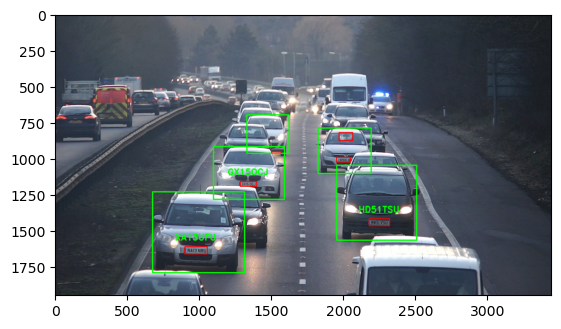

In [12]:
import matplotlib.pyplot as plt

plt.imshow(rgb_result)

plt.show()

In [13]:
reset_tracker()

True

In [14]:
video_path = 'Samples/sample.mp4'
cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
frame_num = -1

In [15]:
cap.set(cv.CAP_PROP_POS_FRAMES,0)
cap.get(cv.CAP_PROP_POS_FRAMES)

0.0

In [16]:
aggregated_result = []

while cap.isOpened():
    ret, frame = cap.read()
    ### limit 10 frame for test purpose
    if not ret or frame_num > 10:
    # if not ret :
        break
    
    frame_num += 1
    # Process frame - detect license plates
    detection_results = crop_vehicle_license_then_read(input_image=frame,vehicle_conf=0.5,license_conf=0.5,frame_number=frame_num)
    aggregated_result.extend(detection_results)
    # # Convert frame to bytes and send



0: 640x640 12 cars, 2 trucks, 19.6ms
Speed: 2.4ms preprocess, 19.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License_Plate, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
2.0

0: 640x640 1 License_Plate, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
3.0

0: 640x640 1 License_Plate, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
4.0

0: 640x640 (no detections), 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.4ms
Speed: 1.6ms preprocess, 7.4ms

In [17]:
import pandas as pd

In [18]:
results_df = pd.DataFrame(aggregated_result)

In [19]:
results_df

,frame_number,track_id,vehicle_bbox,vehicle_bbox_score,lp_bbox,lp_bbox_score,lp_number,lp_text_score
0,0,2.0,"[2171.55126953125, 1159.9171142578125, 2779.58...",0.889529,"[253.49383544921875, 413.6332702636719, 410.15...",0.740174,NO51VSU,0.086785
1,0,3.0,"[752.753173828125, 1365.60791015625, 1458.2739...",0.887984,"[249.3141632080078, 422.5195007324219, 420.575...",0.703346,NA13NRU,0.412271
2,0,4.0,"[1217.6044921875, 1016.239990234375, 1754.2342...",0.870597,"[211.17835998535156, 265.9902038574219, 341.65...",0.522446,GX15OCJ,0.460160
3,1,2.0,"[2172.91357421875, 1162.3701171875, 2780.82299...",0.886420,"[252.04025268554688, 413.3577880859375, 410.31...",0.740925,NV51VSU,0.547408
4,1,3.0,"[754.415283203125, 1368.3546142578125, 1458.87...",0.881615,"[241.1015625, 422.4859313964844, 419.353088378...",0.716219,NA13NRU,0.351058
5,1,4.0,"[1218.2747802734375, 1017.5740966796875, 1754....",0.867036,"[210.408447265625, 267.9928894042969, 342.9821...",0.507812,None,NaN
6,2,2.0,"[2171.220947265625, 1165.79052734375, 2785.644...",0.879974,"[254.3873748779297, 417.74163818359375, 412.80...",0.734120,None,NaN
7,2,3.0,"[746.6083984375, 1374.2415771484375, 1452.4368...",0.889529,"[247.2088623046875, 426.2018737792969, 420.756...",0.707405,NA13NRU,0.535762
8,2,4.0,"[1216.6575927734375, 1019.039306640625, 1755.5...",0.867036,"[207.38687133789062, 268.8304443359375, 339.82...",0.555435,None,NaN
9,2,6.0,"[2032.014404296875, 875.330078125, 2439.318115...",0.838680,"[146.1145782470703, 228.08534240722656, 250.02...",0.541894,None,NaN


In [20]:
cap.set(cv.CAP_PROP_POS_FRAMES,0)
cap.get(cv.CAP_PROP_POS_FRAMES)
frame_num = -1

NO51VSU
NA13NRU
GX15OCJ


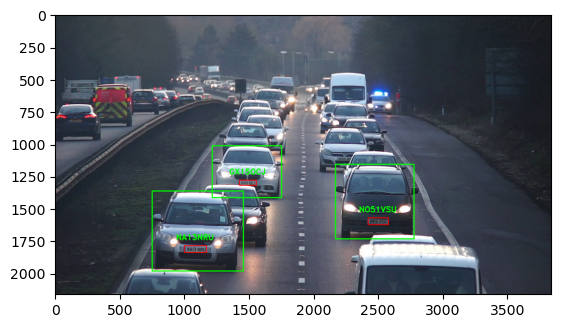

NV51VSU
NA13NRU
None


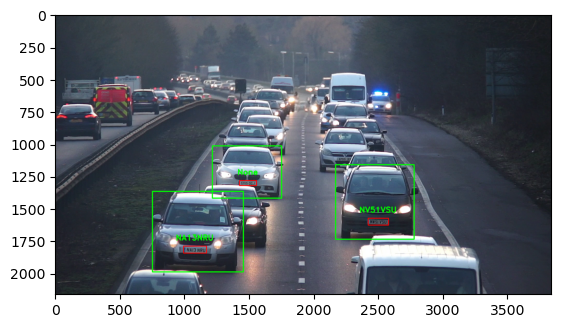

None
NA13NRU
None
None


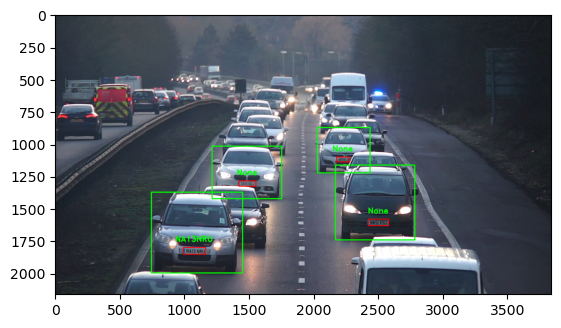

None
NA13NRU
None
None


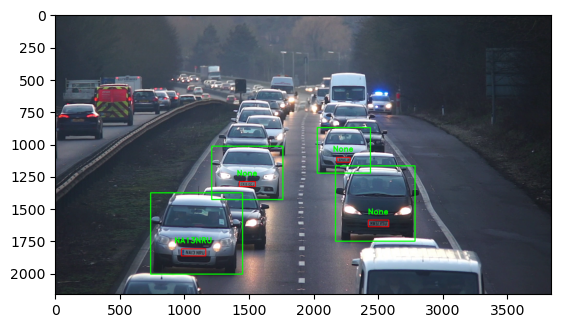

HW51VSU
NA13NRU
None
None
None


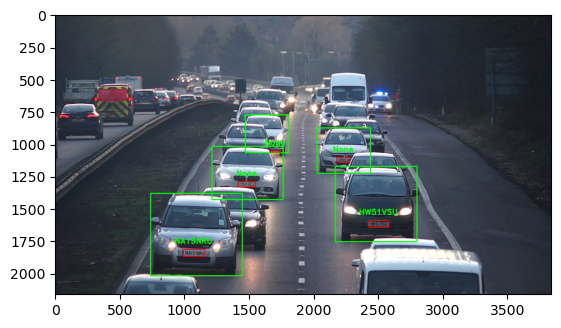

HW51YSU
NA13NRU
None
None
None


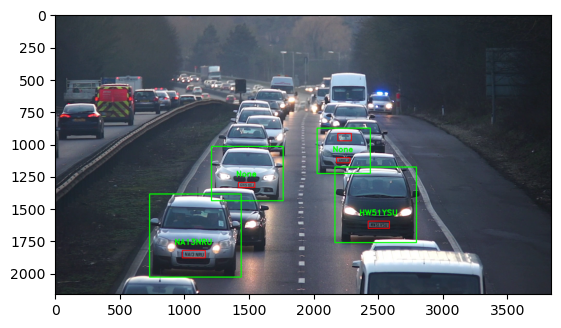

NV51TSU
HA13NRU
GX15OGJ
None


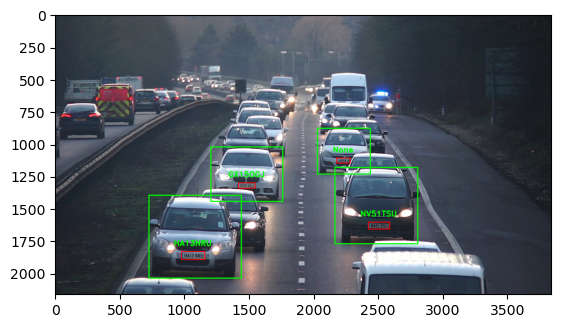

NV51VSU
NA13MRU
GX15OGJ
None


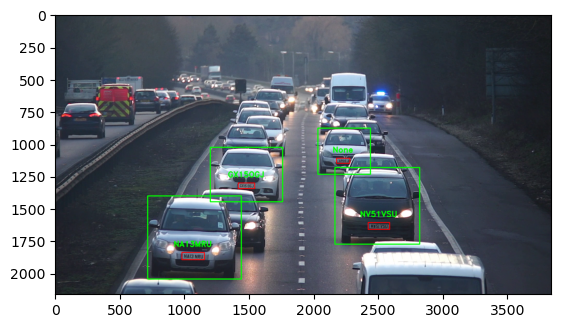

None
NA13NRU
GX15OGJ
None


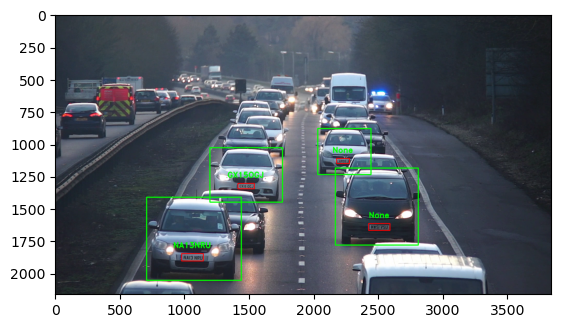

HL51VSU
NA13NRU
GV15OGJ
None


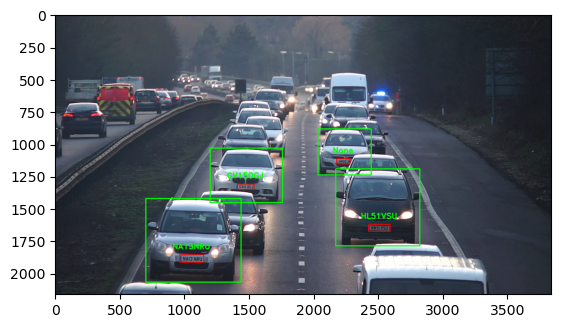

None
NA13NRU
GX15OGJ
None


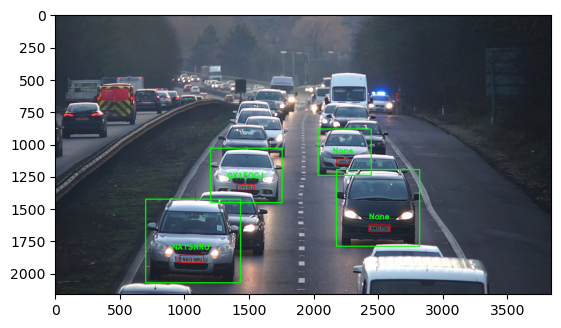

In [21]:
while cap.isOpened():
    frame_num += 1
    ret, frame = cap.read()
    ### limit 10 frame for test purpose
    if not ret or frame_num > 10:
    # if not ret :
        break
    df_ = results_df[results_df['frame_number'] == frame_num]
    for index in range(len(df_)):
        # draw vehicle
        # if str(df_.iloc[index]['lp_number']) != 'nan':
            print(df_.iloc[index]['lp_number'])
            vhcl_x1, vhcl_y1, vhcl_x2, vhcl_y2 = df_.iloc[index]['vehicle_bbox']
            
            # draw_border(frame, (int(vhcl_x1), int(vhcl_y1)),(int(vhcl_x2), int(vhcl_y2)), (0, 255, 0),12, line_length_x=200, line_length_y=200)
            cv.rectangle(frame, (int(vhcl_x1), int(vhcl_y1)),(int(vhcl_x2), int(vhcl_y2)), (0, 255, 0), 8)
            # draw license plate
            plate_x1, plate_y1, plate_x2, plate_y2 = df_.iloc[index]['lp_bbox']

            # region of interest
            roi = frame[int(vhcl_y1):int(vhcl_y2), int(vhcl_x1):int(vhcl_x2)]
            cv.rectangle(roi, (int(plate_x1), int(plate_y1)), (int(plate_x2), int(plate_y2)), (0, 0, 255), 6)

            # write detected number
            # (text_width, text_height), _ = cv.getTextSize(str(df_.iloc[index]['lp_number']),cv.FONT_HERSHEY_SIMPLEX,2,6)

            # cv.putText(frame,str(df_.iloc[index]['lp_number']),(int((vhcl_x2 + vhcl_x1 - text_width)/2), int(vhcl_y1 - text_height)),cv.FONT_HERSHEY_SIMPLEX,2,(0, 255, 0),6)
            
            (text_width, text_height), _ = cv.getTextSize(str(df_.iloc[index]['lp_number']),cv.FONT_HERSHEY_DUPLEX,2,6)
            cv.putText(
                    roi,
                    str(df_.iloc[index]['lp_number']),
                    (int((plate_x2 + plate_x1 - text_width)/2), int(plate_y1 - text_height)),
                    cv.FONT_HERSHEY_DUPLEX,
                    2,
                    (0, 255, 0),
                    6
                )
    rgb_result = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    plt.imshow(rgb_result)
    plt.show()